In [1]:
!mkdir data_lfw
!unzip archive -d data_lfw

Archive:  archive.zip
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Abdullah_Gul/Abdullah_Gul_0001.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Abdullah_Gul/Abdullah_Gul_0002.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Abdullah_Gul/Abdullah_Gul_0003.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Abdullah_Gul/Abdullah_Gul_0004.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Abdullah_Gul/Abdullah_Gul_0005.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Adrien_Brody/Adrien_Brody_0001.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Adrien_Brody/Adrien_Brody_0002.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Adrien_Brody/Adrien_Brody_0003.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Adrien_Brody/Adrien_Brody_0004.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Adrien_Brody/Adrien_Brody_0005.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_witho

In [2]:
!mv data_lfw/Masked_LFW_Dataset/Masked_LFW_Dataset/* data_lfw/Masked_LFW_Dataset
!rmdir data_lfw/Masked_LFW_Dataset/Masked_LFW_Dataset

In [3]:
!mkdir data_lfw/tmp
!mv data_lfw/LFW_without_Mask/LFW_without_Mask/*/* data_lfw/tmp

!rm -rf data_lfw/LFW_without_Mask
!mv data_lfw/tmp data_lfw/LFW_without_Mask

In [4]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2503, done.
remote: Total 2503 (delta 0), reused 0 (delta 0), pack-reused 2503
Receiving objects: 100% (2503/2503), 8.19 MiB | 39.02 MiB/s, done.
Resolving deltas: 100% (1570/1570), done.


In [5]:
!mv data_lfw pytorch-CycleGAN-and-pix2pix

In [6]:
%cd pytorch-CycleGAN-and-pix2pix
!mkdir checkpoints
!mkdir checkpoints/cycle_gan

/home/ubuntu/veronika/temp/pytorch-CycleGAN-and-pix2pix


In [7]:
!pip install -r requirements.txt

-- Download checkpoints for CycleGAN from https://drive.google.com/drive/folders/1rFAqm8GU5pclh6FZLSpmNUyay7knEA40?usp=share_link $\newline$
-- Put them in the folder "pytorch-CycleGAN-and-pix2pix/checkpoints/cycle_gan"

## Remove masks from faces using CycleGAN (create normal-lfw)

In [26]:
!cp checkpoints/cycle_gan/latest_net_G_B.pth checkpoints/cycle_gan/latest_net_G.pth

In [27]:
!python test.py --dataroot data_lfw/Masked_LFW_Dataset --name cycle_gan --model test --no_dropout --results_dir results/mask_to_no_mask --num_test 2002

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: data_lfw/Masked_LFW_Dataset   	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

## Add masks to faces using CycleGAN (create masked-LFW)

In [28]:
!cp checkpoints/cycle_gan/latest_net_G_A.pth checkpoints/cycle_gan/latest_net_G.pth

In [29]:
!python test.py --dataroot data_lfw/LFW_without_Mask --name cycle_gan --model test --no_dropout --results_dir results/no_mask_to_mask --num_test 2115

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: data_lfw/LFW_without_Mask     	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

# Evaluate CycleGan performance on removing masks (open faces vs. normal-LFW)

In [16]:
import os
from tqdm import tqdm
import glob
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
from PIL import Image

In [18]:
def open_img(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (112, 112))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [42]:
def calculate_l2_dist(gt_path, pred_path, suffix="_fake.png"):
    """
    Parameters:
    gt_path (str): path to images with ground truth faces.
    pred_path (str): path to images with generated faces.
    suffix (str): ending of filepath of generated images.

    Returns:
    l2_dist (list): list of l2 distances between ground truth and generated images.
    """
    paths = glob.glob(gt_path + '/*')
    
    l2_dist = []

    for filepath in tqdm(paths):
        gt_img = open_img(filepath)

        pred_filepath = pred_path + '/' + os.path.basename(filepath)[:-4] + suffix
        if os.path.exists(pred_filepath):
            pred_img = open_img(pred_filepath)
        else:
            continue

        dist = np.sum((gt_img - pred_img)**2)
        dist = np.sqrt(dist)
        ch, h, w = gt_img.shape
        l2_dist.append(dist)

    print(f"Mean L2 distance: {np.mean(l2_dist)}")

    return l2_dist

In [43]:
l2_dist = calculate_l2_dist("data_lfw/LFW_without_Mask", "results/mask_to_no_mask/cycle_gan/test_latest/images")

100%|██████████| 2115/2115 [00:10<00:00, 193.17it/s]

Mean L2 distance: 1541.6701399236401


In [19]:
paths = glob.glob("data_lfw/LFW_without_Mask" + '/*')
pred_path = "results/mask_to_no_mask/cycle_gan/test_latest/images"

img_arr = []
count = 0

for filepath in paths:
    gt_img = open_img(filepath)

    pred_filepath = pred_path + '/' + os.path.basename(filepath)[:-4] + '_fake.png'
    if os.path.exists(pred_filepath):
        pred_img = open_img(pred_filepath)
        count += 1
    else:
        continue

    img_arr.append(gt_img)
    img_arr.append(pred_img)

    if count > 5:
        break

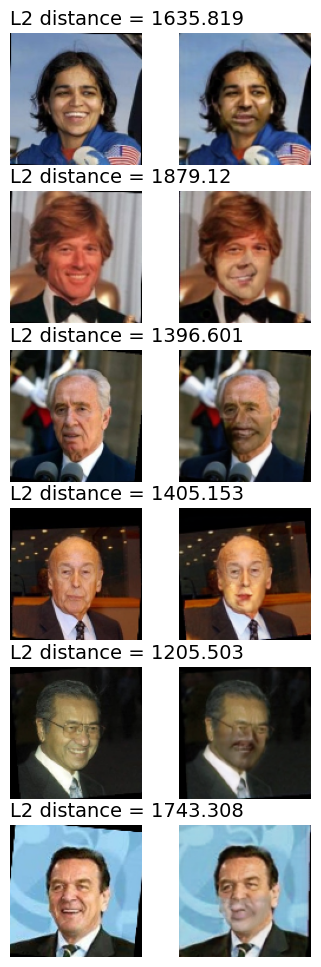

In [21]:
rows = 6
cols = 2
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4,12))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(img_arr):
            axes[i, j].imshow(img_arr[img_count])
            axes[i, j].axis('off')
            img_count += 1
            if j == 0:
                axes[i, j].set_title(f'L2 distance = {np.round(l2_dist[i], 3)}', fontsize=14, loc='left')
                

fig.savefig('example_remove_mask.png', bbox_inches='tight')

In [22]:
img_arr = []

for filepath in tqdm([paths[np.argmin(l2_dist)], paths[np.argmax(l2_dist)]]):
    gt_img = open_img(filepath)

    pred_filepath = pred_path + '/' + os.path.basename(filepath)[:-4] + '_fake.png'
    if os.path.exists(pred_filepath):
        pred_img = open_img(pred_filepath)
    else:
        continue

    img_arr.append(gt_img)
    img_arr.append(pred_img)

100%|██████████| 2/2 [00:00<00:00, 190.29it/s]


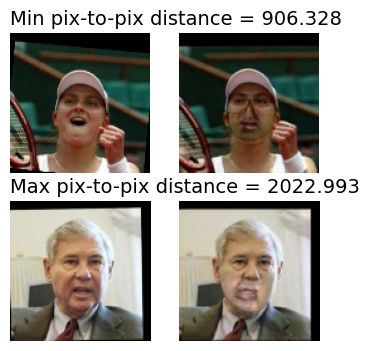

In [23]:
rows = 2
cols = 2
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4,4))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(img_arr):
            axes[i, j].imshow(img_arr[img_count])
            axes[i, j].axis('off')
            img_count += 1
            if i == 0 and j == 0:
                axes[i, j].set_title(f'Min pix-to-pix distance = {np.round(np.min(l2_dist), 3)}', fontsize=14, loc='left')
            elif i == 1 and j == 0:
                axes[i, j].set_title(f'Max pix-to-pix distance = {np.round(np.max(l2_dist), 3)}', fontsize=14, loc='left')

plt.savefig('min_max_dist.png', bbox_inches='tight')

## Remove masks from masked-LFW and compare to normal-lfw (CycleGAN(masked-LFW) vs. normal-LFW)

In [24]:
!mkdir normal-lfw
!mkdir masked-lfw

In [25]:
!cp results/mask_to_no_mask/cycle_gan/test_latest/images/*_fake.png normal-lfw

In [26]:
!cp results/no_mask_to_mask/cycle_gan/test_latest/images/*_fake.png masked-lfw

In [30]:
!cp checkpoints/cycle_gan/latest_net_G_B.pth checkpoints/cycle_gan/latest_net_G.pth

In [31]:
!python test.py --dataroot masked-lfw --name cycle_gan --model test --no_dropout --results_dir results/masked-lfw_to_no_mask --num_test 2115

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: masked-lfw                    	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

In [44]:
l2_dist = calculate_l2_dist("normal-lfw", "results/masked-lfw_to_no_mask/cycle_gan/test_latest/images")

100%|██████████| 2002/2002 [00:09<00:00, 214.09it/s]

Mean L2 distance: 1508.3363486919122


In [31]:
pred_path = "results/masked-lfw_to_no_mask/cycle_gan/test_latest/images"
paths = glob.glob("normal-lfw" + '/*')

img_arr = []
count = 0

for filepath in paths:
    gt_img = open_img(filepath)

    pred_filepath = pred_path + '/' + os.path.basename(filepath)[:-4] + '_fake.png'
    if os.path.exists(pred_filepath):
        pred_img = open_img(pred_filepath)
        count += 1
    else:
        continue

    img_arr.append(gt_img)
    img_arr.append(pred_img)

    if count > 5:
        break

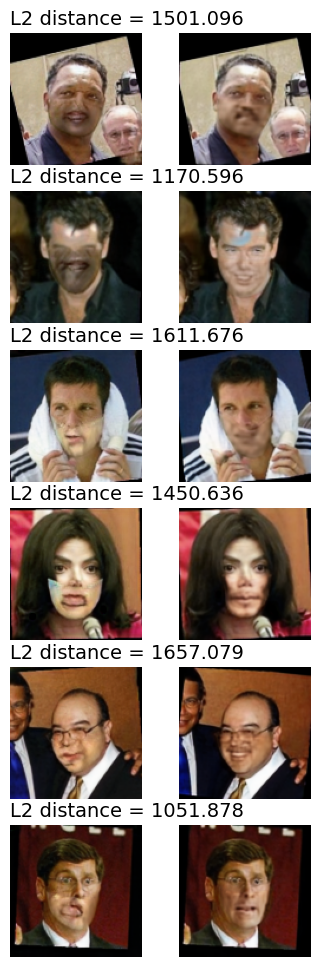

In [32]:
rows = 6
cols = 2
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4,12))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(img_arr):
            axes[i, j].imshow(img_arr[img_count])
            axes[i, j].axis('off')
            img_count += 1
            if j == 0:
                axes[i, j].set_title(f'L2 distance = {np.round(l2_dist[i], 3)}', fontsize=14, loc='left')
                

fig.savefig('example_remove_mask_from_masked-lfw.png', bbox_inches='tight')

## Compare open faces to CycleGAN(masked-LFW)

In [45]:
l2_dist = calculate_l2_dist("data_lfw/LFW_without_Mask", 
                            "results/masked-lfw_to_no_mask/cycle_gan/test_latest/images",
                            "_fake_fake.png")

100%|██████████| 2115/2115 [00:11<00:00, 192.03it/s]

Mean L2 distance: 1120.7265670645102


## Visualize some examples of adding/removing masks

In [36]:
gt_path = "data_lfw/LFW_without_Mask"
pred_path = "results/no_mask_to_mask/cycle_gan/test_latest/images"
paths = glob.glob(gt_path + '/*')
    
img_arr = []

for filepath in tqdm(paths[8:10]):
    gt_img = open_img(filepath)

    pred_filepath = pred_path + '/' + os.path.basename(filepath)[:-4] + '_fake.png'
    if os.path.exists(pred_filepath):
        pred_img = open_img(pred_filepath)
    else:
        continue

    img_arr.append(gt_img)
    img_arr.append(pred_img)

100%|██████████| 2/2 [00:00<00:00, 183.54it/s]


In [37]:
gt_path = "data_lfw/Masked_LFW_Dataset"
pred_path = "results/mask_to_no_mask/cycle_gan/test_latest/images"
paths = glob.glob(gt_path + '/*')

for filepath in tqdm(paths[10:12]):
    gt_img = open_img(filepath)

    pred_filepath = pred_path + '/' + os.path.basename(filepath)[:-4] + '_fake.png'
    if os.path.exists(pred_filepath):
        pred_img = open_img(pred_filepath)
    else:
        continue

    img_arr.append(gt_img)
    img_arr.append(pred_img)

100%|██████████| 2/2 [00:00<00:00, 194.41it/s]


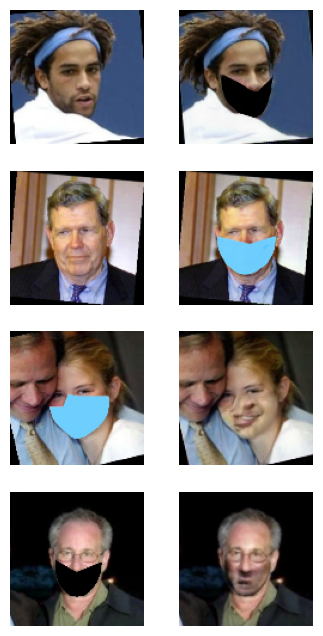

In [38]:
rows = 4
cols = 2
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4,8))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(img_arr):
            axes[i, j].imshow(img_arr[img_count])
            axes[i, j].axis('off')
            img_count += 1
            
plt.savefig('examples_cyclegan.png', bbox_inches='tight')

## Evaluate FID

In [32]:
!pip install pytorch-fid

## Open faces vs Normal-LFW

In [34]:
!python -m pytorch_fid data_lfw/LFW_without_Mask normal-lfw

/home/ubuntu/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|███████████████████████████████████████████| 41/41 [00:08<00:00,  4.94it/s]
FID:  17.897348142553255


## CycleGAN(masked-LFW)/normal-LFW

In [36]:
!mkdir cycle-lfw
!cp results/masked-lfw_to_no_mask/cycle_gan/test_latest/images/*_fake_fake.png cycle-lfw

In [37]:
!python -m pytorch_fid cycle-lfw normal-lfw

/home/ubuntu/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|███████████████████████████████████████████| 41/41 [00:08<00:00,  4.97it/s]
FID:  18.346104455239868


## Open faces vs CycleGAN(masked-LFW)

In [39]:
!python -m pytorch_fid data_lfw/LFW_without_Mask cycle-lfw

/home/ubuntu/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|███████████████████████████████████████████| 43/43 [00:08<00:00,  4.94it/s]
FID:  15.57568701506375


## Train CycleGAN

In [ ]:
%cd ..

In [10]:
!mkdir data_lfw
!unzip archive -d data_lfw

Archive:  archive.zip
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Abdullah_Gul/Abdullah_Gul_0001.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Abdullah_Gul/Abdullah_Gul_0002.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Abdullah_Gul/Abdullah_Gul_0003.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Abdullah_Gul/Abdullah_Gul_0004.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Abdullah_Gul/Abdullah_Gul_0005.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Adrien_Brody/Adrien_Brody_0001.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Adrien_Brody/Adrien_Brody_0002.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Adrien_Brody/Adrien_Brody_0003.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Adrien_Brody/Adrien_Brody_0004.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_without_Mask/Adrien_Brody/Adrien_Brody_0005.jpg  
  inflating: data_lfw/LFW_without_Mask/LFW_witho

In [11]:
!python src/build_cyclegan_training_data.py "data_lfw" "pytorch-CycleGAN-and-pix2pix/datasets/lfw"

100%|██████████████████████████████████████| 823/823 [00:00<00:00, 10278.96it/s]


In [12]:
%cd pytorch-CycleGAN-and-pix2pix

/home/ubuntu/veronika/temp/pytorch-CycleGAN-and-pix2pix


In [ ]:
# !python train.py --dataroot datasets/lfw --name no_mask_to_mask --model cycle_gan --display_id -1 --gpu_ids 0 --batch_size 4